# Splash Test 💧

<div class="alert alert-block alert-success">

## Part 1: Problem Set Up 

We now depart from our bubble tests and move to simulation geometries that will be more akin to what we will use in 2- and 3D planetary simulations. 

In particular we will explore the Splash test, which was developed by [Chen 2021](https://ui.adsabs.harvard.edu/abs/2021JAMES..1302280C/abstract) as a test of shallow-water cubed-sphere models (where we will go into detail on what *shallow water* and *cubed-sphere* mean below).


It was first applied to $\texttt{ExoCubed}$ ([Chen & Li 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...966..123C/abstract)), a model built into $\texttt{PADDLE}$

</div>

<img src="../../images/splash-test-from-Chen2021.png">

From [Chen 2021](https://ui.adsabs.harvard.edu/abs/2021JAMES..1302280C/abstract)

<div class="alert alert-info">

## The Problem

The Splash problem involves initializing a shallow water model on a cubed-sphere and simulating a splash of a sinusoidal droplet on a non-rotating object. 

In practice, this involves putting a mountain of water at one pole and letting it spread (and converge) at the opposite pole. 

</div>


<img src="../../images/atmospheric_model_complexity.png">

From [Poster](https://www.jpl.nasa.gov/site/research/media/posters/2022/SP20004p.pdf)

<div class="alert alert-warning">

$\textbf{Definition: Shallow Water Models}$ are a mid-complexity, 2D atmospheric model (where they are less complex than the commonly used 3D Primitive Equation based models (which make the hydrostatic assumption) or full 3D Navier-Stokes Equations based models (which don't make the hydrostatic assumption)). 

The shallow-water is a simplification of the full Navier-Stokes equations where you make the assumption that the atmosphere is a fluid that is incompressible (constant density) and hydrostatically balanced (gravity balances pressure). 

This simplifies the problem down to the dynamics of a thin (horizontal scale >> vertical scale), single layer (with variable thickness but constant density). These models can track large-scale horizontal perturbations due to forcing like gravity and rotation

While here we explore a simplistic case of a gravitational perturbation, shallow water models have been used to explore dynamical regimes in exoplanets and are useful for exploring large phase-spaces (i.e., see Sub-Neptune shallow water models of [Ekaterina et al. 2023](https://ui.adsabs.harvard.edu/abs/2023PSJ.....4..106L/abstract))

<div class="alert alert-warning">

$\textbf{Definition: Cubed Sphere Grids}$ are a specific grid system used in climate modeling that projects a cube's six faces into the geometry of a sphere, where the interfaces of cube faces communicate with each other inside the simulation. 

This geometry allows for near constant resolution across the entire surface of the sphere, and also avoids the issue of polar convergence that latitude-longitude grids face. 

<img src="../../images/cubed_sphere.png">

From [Chen & Li 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...966..123C/abstract)

<div class="alert alert-info">

## Setting Up the Initial Problem Conditions 

Recall that in both Straka and Robert that we had to transform whatever our imagined initial condition perturbation was to primitive variables (pressure, density, and velocity). In Straka and Robert, that involved transforming a temperature perturbation to one of pressure and density. 

When using the shallow water equations, the primitive variables change slightly due to density being assumed constant. In particular, density is replaced by **geopotential**. 

<div class="alert alert-warning">

$\textbf{Definition: Geopotential Height}$ $(\Phi)$ is the potential of a gravity field, and is in units of m2/s2 or J/kg. 

In shallow water, the geopotential is equal to the height of fluid thickness times gravity. In shallow water simulations, flows (in the absence of rotation) are initiated by elevation and gravity, and propagate due to conservation of mass and momentum. 

Therefore, we define our initial condition with geopotential. 

</div>

<img src="../../images/geopotential-behavior-elevation-gravity.jpg">

From [NOAA](https://geodesy.noaa.gov/research/geopotential-datums/geopotential-surface.shtml).

<div class="alert alert-warning">

$$
\Phi_{\mathrm{init}} = \begin{cases}
    \Phi_0 + \mathrm{d}\Phi & \text{if } r < R \\
    \Phi_0  & \text{otherwise}\\
\end{cases}
$$

Where r is distance from the North Pole where we initialize the perturbations, R is radius of the perturbation, $\Phi_0$ is the global geopotential, and $\mathrm{d}\Phi$ is the amplitude of the change of geopotential. 

Here our parameters are chosen so that it takes **10 days** for the wave to reach the south pole (for an Earth-like planet): 

R   = 500 km 

$\Phi_0$ = 50 meters x g 

$\mathrm{d}\Phi$ = 1 meter * g

where g is the gravitational acceleration. 

*Note, in [Chen & Li 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...966..123C/abstract) there is a form of the perturbation with a cosine term that smooths out the initial condition splash. Here, we are assuming the more simplified 'block splash'*

</div>

In order to see what this initial condition, lets define a latitude-longitude grid. 

In [13]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# Lets make a latitude-longitude grid 
min_lat, max_lat = -90, 90.  # South, North
min_lon, max_lon = -180, 180 # West, East
spacing = 1 # in degrees

# Create 1D arrays for latitudes and longitudes
lats = np.arange(min_lat, max_lat + spacing, spacing)
lons = np.arange(min_lon, max_lon + spacing, spacing)

# Create 2D coordinate grids using meshgrid
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Convert to radians
lon_grid_radians = np.radians(lon_grid)
lat_grid_radians = np.radians(lat_grid)

<div class="alert alert-warning">

In order to define distance from a given latitude to the North Pole, we need to figure out the *arc length (s)*. 

$s = R_p * \theta$

Where $R_p$ is the radius of the planet and $\theta$ is the angle in radians. Here, we define the North Pole as having a latitude of 90 $^\circ$ (or, in radians, $\pi/2$). 

Therefore, the distance from the north pole to a given latitude is 

$s = R_p * \theta_{Np\rightarrow lat} = R_p * (\frac{\pi}{s}-lat)$ 

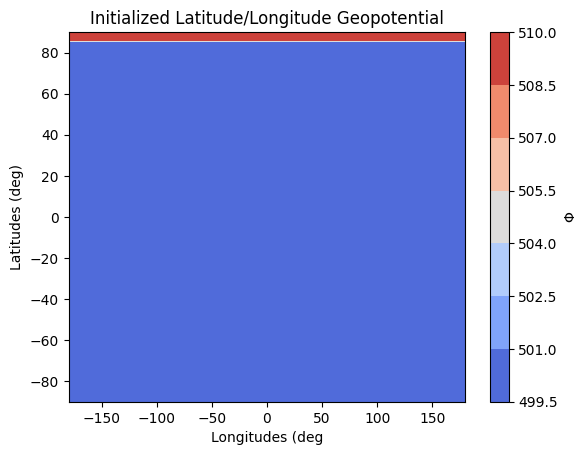

In [16]:
# Phi_0 = 50 m x g = 500 m2/s2
Phi_0 = 500

# dPhi = 1 m * g = 10 m2/s2
dPhi = 10

# Radius of perturbation is 500 km 
R_perturbation = 5e5 # m

# Will assume the radius is that of Earth
R_planet =  6.371e6 # meters

# Distance from every point on the lat-lon grid from the North Pole 
arc_length = R_planet * ((np.pi / 2.0) - lat_grid_radians)

# Create geo-potential initial condition 
# When arc length is less than R_perturbation it is phi_0 + dphi, 
# Otherwise, it is just phi_0
geopotential = np.where(arc_length < R_perturbation, Phi_0 + dPhi, Phi_0)

# Plot in 2D 
plt.contourf(lon_grid,lat_grid,geopotential, cmap = 'coolwarm')
plt.title(r'Initialized Latitude/Longitude Geopotential')
plt.xlabel('Longitudes (deg')
plt.ylabel('Latitudes (deg)')
plt.colorbar(label = r'$\Phi$')

For better visualization, we can also put this onto a 3D sphere

(181, 361) (181, 361)


Text(0.5, 0, 'Meters')

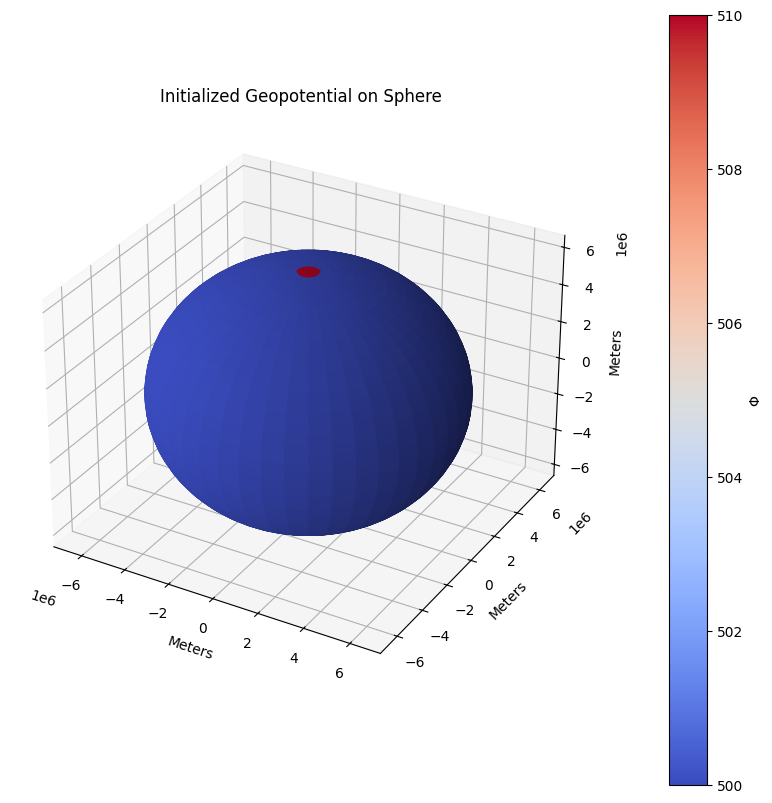

In [ ]:
# Oftentimes, the radian versions of lat and lon are called phi and theta 
phi   = lon_grid_radians # Azimuthal angle
theta = lat_grid_radians # Polar angle

# Convert lat-lon to catesian 
x = R_planet * np.cos(theta) * np.cos(phi)
y = R_planet * np.cos(theta) * np.sin(phi)
z = R_planet * np.sin(theta)

# Normalize geopotential for colormap 
N = (geopotential - np.min(geopotential))/(np.max(geopotential) - np.min(geopotential))

# Colormap 
cmap = cm.coolwarm

# Plot geopotential on the sphere 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, facecolors=cmap(N))

# Create a colorbar 
m = cm.ScalarMappable(cmap=cmap)
# Set this for the scaling from normalized 
m.set_array(geopotential) 
# Add the colorbar 
plt.colorbar(m, ax=ax, pad=0.1, label = r'$\Phi$')

plt.title(r'Initialized Geopotential on Sphere')
ax.set_xlabel('Meters')
ax.set_ylabel('Meters')
ax.set_zlabel('Meters')

For visual effect, we can turn the geopotential into an altitude 

$Z_\Phi = \frac{\Phi}{g}$

Here, since the difference is so miniscule compared to the (X,Y,Z) dimensions, we will also enlarge the geopotential at the pole. 

Text(0.5, 0, 'Meters')

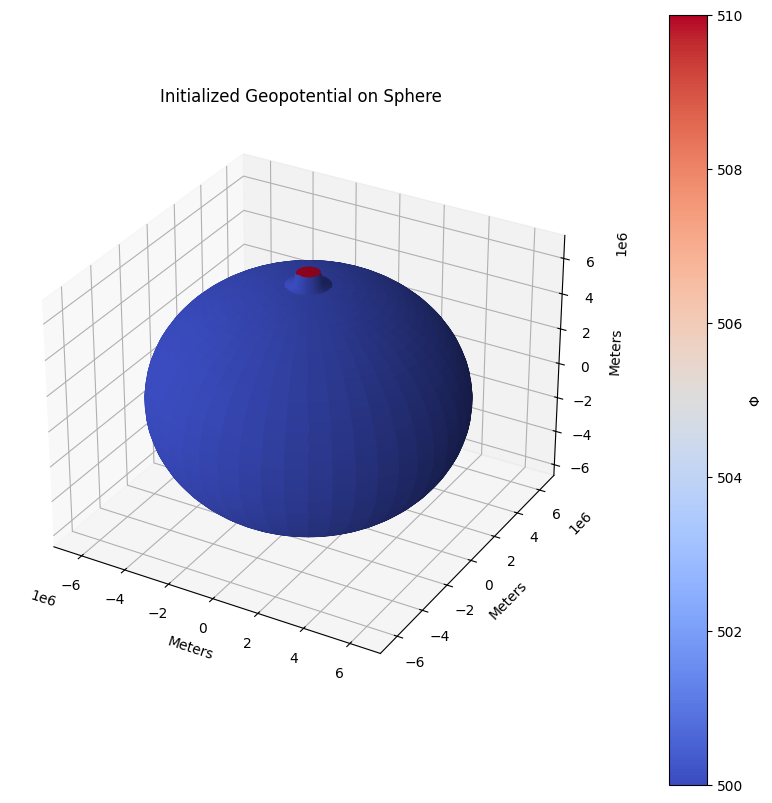

In [42]:
# Oftentimes, the radian versions of lat and lon are called phi and theta 
phi   = lon_grid_radians # Azimuthal angle
theta = lat_grid_radians # Polar angle

# Convert lat-lon to catesian 
x = R_planet * np.cos(theta) * np.cos(phi)
y = R_planet * np.cos(theta) * np.sin(phi)
z = R_planet * np.sin(theta)

# Normalize geopotential for colormap 
N = (geopotential - np.min(geopotential))/(np.max(geopotential) - np.min(geopotential))

# Add the geopotential height 
z += (geopotential/10)

# Stretch aspect ratio at the pole for visual effect
z[geopotential > Phi_0] *= 1.1

# Colormap 
cmap = cm.coolwarm

# Plot geopotential on the sphere 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, facecolors=cmap(N))

# Create a colorbar 
m = cm.ScalarMappable(cmap=cmap)
# Set this for the scaling from normalized 
m.set_array(geopotential) 
# Add the colorbar 
plt.colorbar(m, ax=ax, pad=0.1, label = r'$\Phi$')

plt.title(r'Initialized Geopotential on Sphere')
ax.set_xlabel('Meters')
ax.set_ylabel('Meters')
ax.set_zlabel('Meters')

<div class="alert alert-block alert-success">

Great! So we have a good idea of our initial condition, and key parameters for the shallow water model (like geopotential).

Now lets go to **Part 2**, where we discuss the `.yaml` file. Like we did for **Straka**, we will develop the `.yaml` in detail since we are moving to a new geometry. 